In [41]:
# This notebook follows the setup on learnpytorch by Daniel Bourke
# https://www.learnpytorch.io/08_pytorch_paper_replicating/#7-create-the-transformer-encoder

In [37]:
# An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale https://arxiv.org/abs/2010.11929
# Focusing to building the ViT architecture as per the original Vit paper and applying it to FoodVision Mini.
# 

# Step-by-step approach
"""
0. Getting setup                                    [DONE]
1. Getting data                                     [DONE]
2. Create Dataset and Dataloaders                   [DONE]
3. ViT paper Keypoints: an Overview                 [DONE]
4. Replicating ViT architecture                     [DONE]
    4.1. Equation 1: The Patch Embedding            [DONE]
    4.2. Equation 2: Multi-Head Attention (MSA)     [DONE]
    4.3. Equation 3: Multilayer Perceptron          [DONE]
    4.4. Creating the Transformer Encoder           [DONE]
    4.5. Putting all together to create ViT model   [DONE]
5. Setting up training code for ViT model           [DONE]
6. Using a pretrained ViT from torchvision.models   [DONE]
7. Make predictions on a custom Image               [DONE]
"""
#


### 0. Getting Setup

In [3]:
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print("installing torch, torchvision and torchaudio")
    %pip install -U torch torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchinfo import summary

from modular import data_setup, engine
from modular.utils import download_data, set_seeds, plot_loss_curves

# Set device to cuda
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

torch version: 2.2.2+cu121
torchvision version: 0.17.2+cu121


/home/ville/miniconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


### 1. Get data

In [4]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")

[INFO] data/pizza_steak_sushi directory exists, skipping download.


In [5]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

### 2. Create Datasets and Dataloaders

In [6]:
# From ViT paper
original_batch_size = 4096
training_resolution = 224

IMG_SIZE = training_resolution

# Prepare transforms for images
manual_transforms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])
print(f'Transforms to be applied: {manual_transforms}')

Transforms to be applied: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
BATCH_SIZE = 8

print(data_setup.NUM_WORKERS) # 8 in my laptop

#torchvision can give class names from foldernames
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=manual_transforms, batch_size=BATCH_SIZE, num_workers=8)
print(train_dataloader, test_dataloader, class_names)

8
<torch.utils.data.dataloader.DataLoader object at 0x7f3c88f51880> <torch.utils.data.dataloader.DataLoader object at 0x7f3c88f53e90> ['pizza', 'steak', 'sushi']


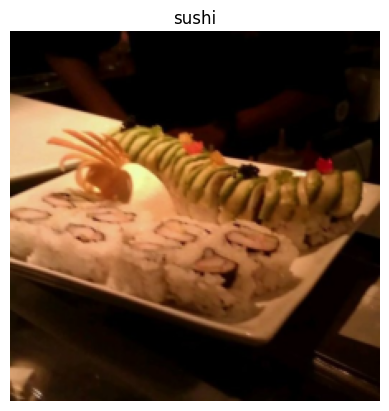

In [8]:
# Visualize single image
img_batch, label_batch = next(iter(train_dataloader))
img, label = img_batch[0], label_batch[0]

plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
plt.show()
plt.close()

### 3. ViT paper Keypoints

#### Architecture
![image.png](vit_architecture.png)
![image-2.png](vit_equations.png)
![image-3.png](vit_variants.png)


- **Patch + Position Embedding (inputs)** 
    - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
- **Linear projection of flattened patches (Embedded Patches)** 
    - The image patches turned into an embedding, the benefit of using an embedding rather than just the image values is that an embedding is a learnable representation (typically in the form of a vector) of the image that can improve with training.
- **Norm ("Layer Normalization" or "LayerNorm")** 
    - a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer torch.nn.LayerNorm().
- **Multi-Head Attention** 
    - This is a Multi-Headed Self-Attention layer or "MSA" for short. You can create an MSA layer via the PyTorch layer torch.nn.MultiheadAttention().
- **MLP (or Multilayer perceptron)** 
    - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a forward() method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two torch.nn.Linear() layers with a torch.nn.GELU() non-linearity activation in between them (section 3.1) and a torch.nn.Dropout() layer after each.
- **Transformer Encoder** 
    - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
- **MLP Head** 
    - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

#### Equations
##### Equation 1 Patch embedding layer
$$
z_0 = \left[ x_{\text{class}}; x_{p}^{1}E; x_{p}^{2}E; \dots; x_{p}^{N}E \right] + E_{\text{pos}}, \quad E \in \mathbb{R}^{(P^2 \cdot C) \times D}, \quad E_{\text{pos}} \in \mathbb{R}^{(N+1) \times D}
$$
This equation deals with the class token, patch embedding and position embedding (E is for embedding) of the input image. Example:
```
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...] \
Where each of the elements in the vector is learnable (their requires_grad=True)
```

##### Equation 2 MSA Block
$$
z_{\ell}' = MSA(\ln(z_{\ell-1})) + z_{\ell-1}, \quad \ell = 1 \ldots L
$$
This says that for every layer from 1 to L (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN). \
The addition on the end is the equivalent of adding the input to the output and forming a skip/residual connection. \
Pseudo example:
```
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```

##### Equation 3 MLP Block
$$
z_{\ell} = MLP(\ln(z'_{\ell})) + z'_{\ell}, \quad \ell = 1 \ldots L
$$
This says that for every layer from 1 to L (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN). \
The addition on the end is showing the presence of a skip/residual connection. \
 Pseudo example:
```
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```

##### Equation 4 MLP Head (Final Transformation)
$$
y = \ln(z_{0}^{L})
$$
This says for the last layer L, the output y is the 0 index token of z wrapped in a LayerNorm layer (LN). Or in our case, the 0 index of x_output_MLP_block:
```
y = Linear_layer(LN_layer(x_output_MLP_block[0]))
```

### 4. Replicate ViT architecture

1. Create PatchEmbeddings
2. Transformer Encoder layer
3. Stack multiple transformer encoder layers on top of each other
4. MLP head
5. All together

In [9]:
# 1. Create a class with subclasses nn.Module 
class PatchEmbedding(nn.Module):
# 2. Initialize class
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
# 2. Create a patch embeddings
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
# 3. Create a flatten layer
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

# 4. Define forward layer
    def forward(self, x):
        x = self.patcher(x)
        x = self.flatten(x)
        return x.permute(0,2,1) # # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
        

In [10]:
class ViT(nn.Module):
        def __init__(self,
                     img_size=224,
                     num_channels=3,
                     patch_size=16,
                     embedding_dim=768,
                     dropout=0.1,
                     mlp_size=3072,
                     num_transformer_layers=12,
                     num_heads=12,
                     num_classes=1000):
                super().__init__()

        # 1. Create patch_embeddings
                self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                                patch_size=patch_size,
                                                embedding_dim=embedding_dim)

        # 2. Create class token
                self.class_token = torch.nn.Parameter(torch.rand(1, 1, embedding_dim), requires_grad=True)
        # 3. Create positional embedding
                number_of_patches = int((img_size*img_size)/patch_size**2) # image size of 224x224 convolved with patch_size of 16 will divide image to 14 x 14 patches = 196 total
                self.position_embedding = torch.nn.Parameter(torch.rand(1, number_of_patches+1, embedding_dim), requires_grad=True)
        # 4. Create patch + position embedding dropout
                self.embedding_dropout = torch.nn.Dropout(p=dropout)
        

        # 5. Stack Transformer encoder layers. You have to create the single layer here. Because the TransformerEncoder otherwise stacks one extra layer.
                self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layer=torch.nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                                                      nhead=num_heads,
                                                                                                                      dim_feedforward=mlp_size,
                                                                                                                      dropout=dropout,
                                                                                                                      activation="gelu",
                                                                                                                      batch_first=True,
                                                                                                                      norm_first=True),
                                                                                                                      num_layers=num_transformer_layers)
        # 6. Create MLP head
                self.mlp_head = torch.nn.Sequential(
                        torch.nn.LayerNorm(normalized_shape=embedding_dim),
                        torch.nn.Linear(in_features=embedding_dim,
                                        out_features=num_classes))
        
        def forward(self,x):
                # get some dimensions from x
                batch_size = x.shape[0]

                #create patch_embedding.
                x = self.patch_embedding(x)
                #print(x.shape)

                # first expand class token across the batch size.
                class_token = self.class_token.expand(batch_size, -1, -1)
                #print(class_token.shape)
                
                # prepend class token to patch embedding.  In architecture you can see this is separate item before image patches [*] marked as this
                x = torch.cat((class_token, x), dim=1)
                #print(x.shape)

                # add the positional embedding to patch embedding witht class token. In architecture image this refers to [0], [1], ... [N] times. 9 in example. 
                x = self.position_embedding + x
                #print(x.shape)

                # add dropout
                x = self.embedding_dropout(x)

                # pass embedding through transformer encoder stack
                x = self.transformer_encoder(x)
                #print(x.shape)

                #pass 0th index of x through MLP head (Remember the shape of x [batch, patches, embeddings)
                x=self.mlp_head(x[:,0])
                #print(x.shape)

                #return x
                return x

In [11]:
n_classes = len(class_names)
vit=ViT(num_classes=n_classes).to(device)
summary(model=vit)

/home/ville/miniconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Layer (type:depth-idx)                                            Param #
ViT                                                               152,064
├─PatchEmbedding: 1-1                                             --
│    └─Conv2d: 2-1                                                590,592
│    └─Flatten: 2-2                                               --
├─Dropout: 1-2                                                    --
├─TransformerEncoder: 1-3                                         --
│    └─ModuleList: 2-3                                            --
│    │    └─TransformerEncoderLayer: 3-1                          7,087,872
│    │    └─TransformerEncoderLayer: 3-2                          7,087,872
│    │    └─TransformerEncoderLayer: 3-3                          7,087,872
│    │    └─TransformerEncoderLayer: 3-4                          7,087,872
│    │    └─TransformerEncoderLayer: 3-5                          7,087,872
│    │    └─TransformerEncoderLayer: 3-6             

In [12]:
# Test if our model works. Yes it Does
demo = torch.rand(1,3,224,224).to(device)
print(demo.shape)
vit(demo)

torch.Size([1, 3, 224, 224])


tensor([[ 1.3367, -0.1109,  0.2990]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

### 5. Training Code for ViT Model

In [13]:
#Ok this would work but takes too much resources so lets try with pretrained weights

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.003,
                             betas=(0.9,0.999),
                             weight_decay=0.3)
loss_function = torch.nn.CrossEntropyLoss()

set_seeds()

#result = engine.train(model=vit,
#                      train_dataloader=train_dataloader,
#                      test_dataloader=test_dataloader,
#                      optimizer=optimizer,
#                      loss_fn=loss_function,
#                      epochs=1,
#                      device=device)
#
# 

### 6. Use pretrained ViT model

In [22]:
# import ViT feature detector

# Download pretrained VIT with weights
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

In [23]:
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [24]:
# same than in tensorflow trainable false. So does not update weights
for param in pretrained_vit.parameters():
    param.requires_grad = False

embedding_dim = 768
n_classes = len(class_names)


set_seeds()
pretrained_vit.heads = nn.Sequential(nn.Linear(in_features=embedding_dim, out_features=n_classes, bias=True))

summary(model = pretrained_vit,
        input_size = (1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [38]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=16) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [27]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

 10%|█         | 1/10 [00:42<06:25, 42.84s/it]

Epoch: 1 | train_loss: 0.6300 | train_acc: 0.7875 | test_loss: 0.3372 | test_acc: 0.9386


 20%|██        | 2/10 [01:22<05:29, 41.15s/it]

Epoch: 2 | train_loss: 0.2221 | train_acc: 0.9458 | test_loss: 0.2143 | test_acc: 0.9011


 30%|███       | 3/10 [02:01<04:41, 40.21s/it]

Epoch: 3 | train_loss: 0.1427 | train_acc: 0.9667 | test_loss: 0.2018 | test_acc: 0.9261


 40%|████      | 4/10 [02:40<03:58, 39.75s/it]

Epoch: 4 | train_loss: 0.1079 | train_acc: 0.9750 | test_loss: 0.1855 | test_acc: 0.9318


 50%|█████     | 5/10 [03:20<03:18, 39.64s/it]

Epoch: 5 | train_loss: 0.0850 | train_acc: 0.9833 | test_loss: 0.1829 | test_acc: 0.9318


 60%|██████    | 6/10 [03:59<02:37, 39.37s/it]

Epoch: 6 | train_loss: 0.0760 | train_acc: 0.9875 | test_loss: 0.1773 | test_acc: 0.9318


 70%|███████   | 7/10 [04:38<01:57, 39.26s/it]

Epoch: 7 | train_loss: 0.0597 | train_acc: 0.9917 | test_loss: 0.1877 | test_acc: 0.9443


 80%|████████  | 8/10 [05:17<01:18, 39.39s/it]

Epoch: 8 | train_loss: 0.0479 | train_acc: 0.9917 | test_loss: 0.1794 | test_acc: 0.9443


 90%|█████████ | 9/10 [05:57<00:39, 39.47s/it]

Epoch: 9 | train_loss: 0.0484 | train_acc: 0.9958 | test_loss: 0.1788 | test_acc: 0.9443


100%|██████████| 10/10 [06:37<00:00, 39.72s/it]

Epoch: 10 | train_loss: 0.0373 | train_acc: 0.9958 | test_loss: 0.1793 | test_acc: 0.9193


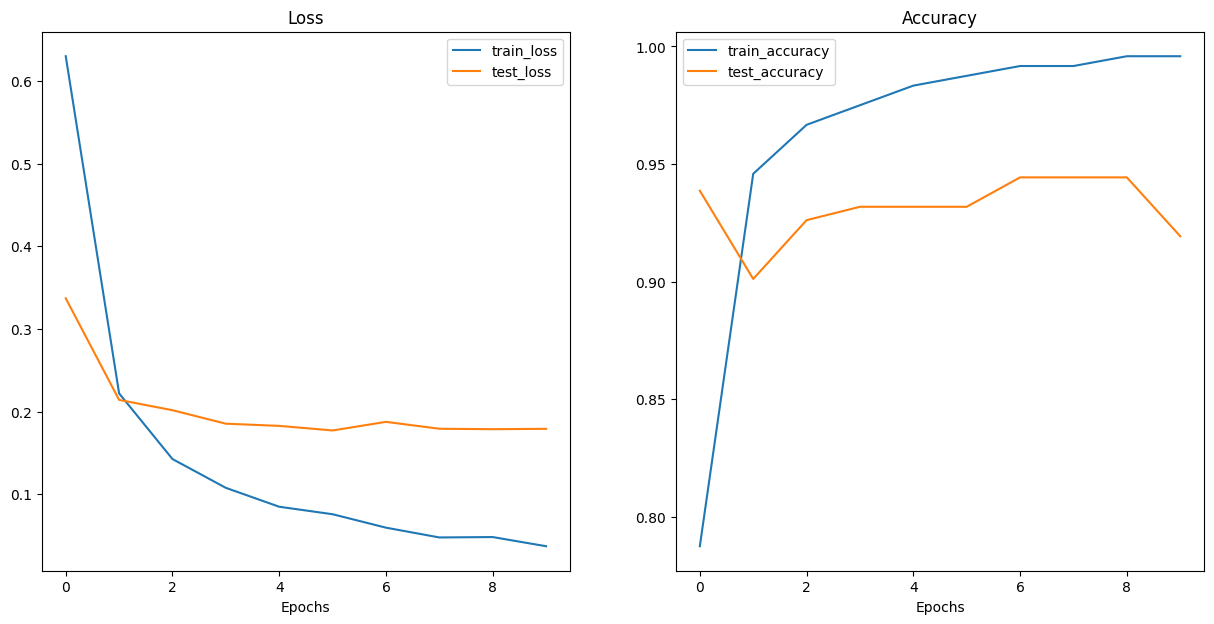

In [28]:
# Plot the loss curves
plot_loss_curves(pretrained_vit_results)

### 7. Predict on custom image

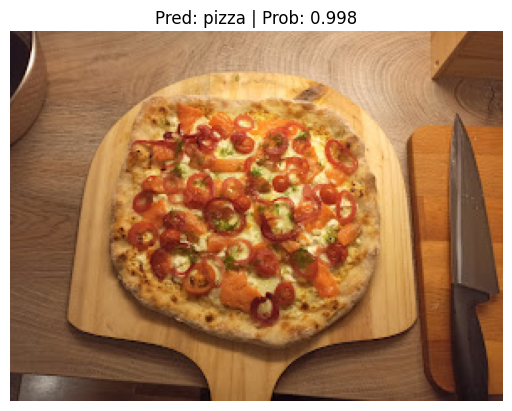

In [33]:
import requests

# Import function to make predictions on images and plot them
from modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "data/sample.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)